In [1]:
# imports all the modules needed
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner
import arviz

import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..', 'scripts'))
import pygravlens as gl
from astropy.cosmology import Planck18 as cosmo
from matplotlib.patches import Arc
from pathlib import Path

In [2]:
### toy model - shear

num = 10**4

EinsArr = np.random.uniform(1.0, 1.5, num) 

r = np.sqrt(np.random.uniform(0.0, 9.0, num)) # sqrt(9) = 2*1.5 = 3.0
theta_im = np.random.uniform(0, 2*math.pi, num)
im1 = [];
im2 = [];

# accounting for red-shift:
zlens = np.random.uniform(0.2, 0.5, num);
zsrc = np.random.uniform(1.0, 3.0, num);

Dlens = [];
Dsrc = [];

def random_shear(nran,mu=0.05,sg=0.2):
    return np.random.lognormal(mean=np.log10(mu)/np.log10(np.e),sigma=sg/np.log10(np.e),size=nran)

def random_ellip(nran,mu=0.3,sg=0.16,ehi=0.9):
    # note: in order to ensure that we have enough values after truncation, we initially draw extra values
    tmp = np.random.normal(loc=mu,scale=sg,size=2*nran)
    # do the truncation
    tmp = tmp[(tmp>=0)&(tmp<0.9)]
    # return the first nran values from the truncated array
    return tmp[:nran]

shear_vals = random_shear(num)
ellip_vals = random_ellip(num)

# random theta vals

ec = [];
es = [];
gc = [];
gs = [];

theta_e = np.random.uniform(0, 2*math.pi, num)
theta_g = np.random.uniform(0, 2*math.pi, num)

for i in range(num):
    ec.append(ellip_vals[i]*np.cos(2*theta_e[i]))
    es.append(ellip_vals[i]*np.sin(2*theta_e[i]))
    gc.append(shear_vals[i]*np.cos(2*theta_g[i]))
    gs.append(shear_vals[i]*np.sin(2*theta_g[i]))

for i in range(num):
    Dlens.append(cosmo.comoving_distance(zlens[i]));
    Dsrc.append(cosmo.comoving_distance(zsrc[i]));

for i in range(num):
    im1.append(r[i]*np.cos(theta_im[i]));
    im2.append(r[i]*np.sin(theta_im[i]));


for i in range(num):
    plane_elpow = gl.lensplane('ellpow', [0.0, 0.0, 1.0, EinsArr[i], 0.0, 0.0], gammac=gc[i], gammas=gs[i], Dl=Dlens[i])

model_elpow = gl.lensmodel([plane_elpow], Ds=Dsrc[i])
model_elpow.tile()

c:\Users\satya\Documents\GravLensing\notebooks\..\scripts\pygravlens.py:1571: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


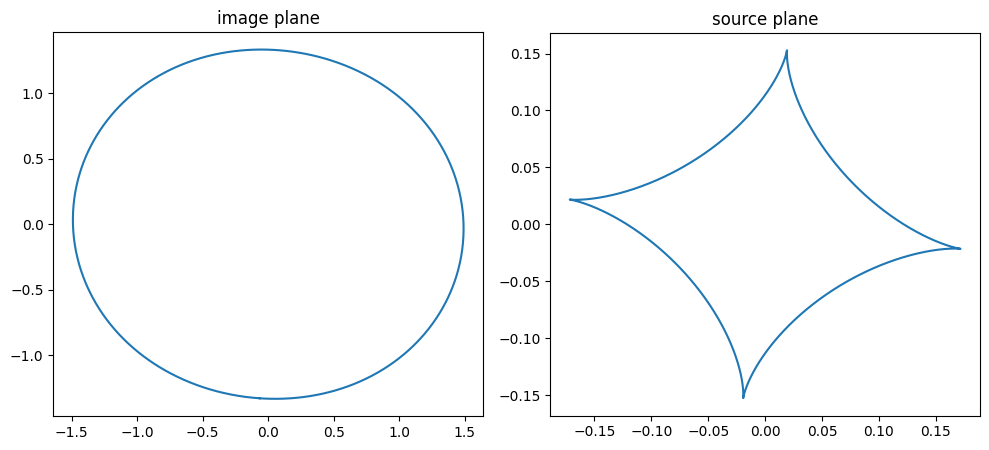

In [3]:
model_elpow.plotcrit()

### list of points on the critical curve
critical_points = model_elpow.crit

### list of points on the caustic curve
caustic_points = model_elpow.caus

In [4]:
print(critical_points)
print(caustic_points)

[array([[-0.06513026, -1.32798925],
       [-0.06982212, -1.32765531],
       [-0.0751503 , -1.32728122],
       ...,
       [-0.04509018, -1.32924082],
       [-0.05511022, -1.32864427],
       [-0.06513026, -1.32798925]])]
[array([[0.01917237, 0.15151749],
       [0.01917781, 0.15164783],
       [0.01918341, 0.15176966],
       ...,
       [0.01915421, 0.1509274 ],
       [0.01916242, 0.15123498],
       [0.01917237, 0.15151749]])]


In [5]:
### use function for the lens equation not the findsrc function.
src = []
mag_tensor = []
time_del = []

for i in range(num):
    src_i, mag_tensor_i, time_del_i = model_elpow.lenseqn([im1[i], im2[i]])
    src.append(src_i)
    mag_tensor.append(mag_tensor_i)
    time_del.append(time_del_i)
    
 
print(src)

[array([0.36267151, 0.67361289]), array([ 1.41745428, -0.29355258]), array([1.16410208, 0.73299121]), array([-0.18217973,  0.66897721]), array([1.46797752, 0.05206047]), array([-0.90875673,  0.195059  ]), array([-0.39520383, -0.81441304]), array([-0.85818228,  0.42749797]), array([0.35360031, 0.06723725]), array([ 0.00993688, -0.07779029]), array([ 0.76399866, -1.02840253]), array([-0.0484828 , -0.12939333]), array([-0.01392011,  0.02913542]), array([0.05742006, 1.1591281 ]), array([-0.26847511, -0.99767675]), array([ 1.03369374, -1.05422085]), array([0.00736265, 0.1105372 ]), array([-1.50571195, -0.64044976]), array([-0.06810531,  0.88558593]), array([ 0.01382863, -0.04217675]), array([ 0.59642834, -0.61147827]), array([-1.05210382,  0.41539626]), array([-0.15777888,  0.67455431]), array([0.04871645, 0.55374867]), array([ 1.22115069, -0.04335472]), array([0.18607811, 0.67283589]), array([0.97825463, 0.70119645]), array([-0.55852958, -0.90581711]), array([ 0.41590564, -0.15924442]), ar

Text(0.5, 1.0, 'Graph of Image Positions (SIS+shear)')

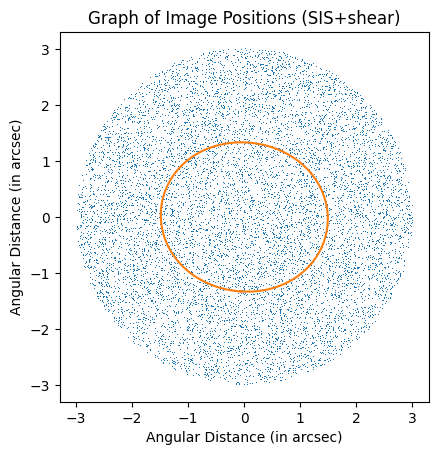

In [6]:
imX = []
imY = []

images = [[im1[i], im2[i]] for i in range(num)]

for elem in images:
    # elem is [x, y] where both are np.float64
    imX.append(float(elem[0]))  # Convert np.float64 to regular float
    imY.append(float(elem[1]))  # Convert np.float64 to regular float

newX = np.array(imX)
newY = np.array(imY)

critical_point = critical_points[0]

crit_x = critical_point[:,0]
crit_y = critical_point[:,1]

plt.plot(newX, newY, ',')
plt.plot(crit_x, crit_y)
plt.gca().set_aspect('equal')
plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Image Positions (SIS+shear)')

Text(0.5, 1.0, 'Graph of Source Positions (SIS+shear)')

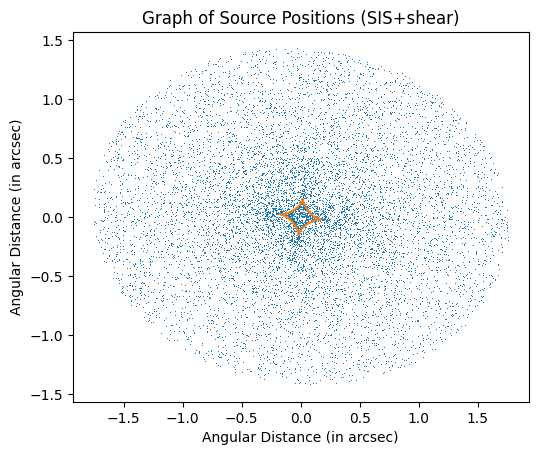

In [7]:
# the set of images covers the critical curves
# 

betaOne = [src[i][0] for i in range(len(src))]
betaTwo = [src[i][1] for i in range(len(src))]


caustic_point = caustic_points[0]

caus_x = caustic_point[:,0]
caus_y = caustic_point[:,1]

plt.plot(betaOne,betaTwo, ',')
plt.plot(caus_x,caus_y)

plt.gca().set_aspect('equal') 

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Source Positions (SIS+shear)')